In [2]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt
import random


default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

In [3]:
def grad(outputs, inputs):
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

In [ ]:
xboundary=torch.tensor([1,1])
xboundary.shape

a=torch.cat((xboundary, xboundary))
a.shape

cpts=torch.sinh(2.0*torch.tensor([random.random() for i in range(10*300)], requires_grad=True))
cpts=cpts.view(3000,1)
#cpts = torch.column_stack((torch.tensor([random.random() for i in range(3)], requires_grad=True), torch.tensor([random.random() for i in range(3)], requires_grad=True)))
cpts.shape

torch.Size([3000, 1])

In [10]:
#Make an NN (try #7: knowing lambda, penalize second deriv)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class burgerslf(torch.nn.Module):
    def __init__(
        self,
        input_dim=1, #1, y(x and t)
        output_dim=1, #2, U and lambda
        N=100,
        l=0.5,
        epochs=3000,
        lr=1e-4,
    ):
        super().__init__()

        self.epochs = epochs
        self.lr = lr
        self.N = N
        self.l=l

        self.layers = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
        )
        self.out = nn.Linear(20, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)
        return out


    def Train(self):

        #for cpts use y=sinh(random), as tristan paper
        cpts=torch.sinh(2.0*torch.tensor([random.random() for i in range(5*self.N)], requires_grad=True))
        cpts=cpts.view(5*self.N, 1)

        start=time.time()
        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()


        def loss_g():
          U_2=(self.Model(torch.tensor([2.0]).view(1,1))[:,0] - self.Model(torch.tensor([-2.0]).view(1,1))[:,0])/2.0
          loss=(U_2-1.0)**2
          return loss.mean()

        def loss_f(input):
          U = (self.Model(input)[:,0] - self.Model(-1*input)[:,0])/2.0 #the odd part of the model
          #print('U shape{}'.format(U.shape))
          Uy=grad(U,input)[0].view(input.shape[0])
          Uyy=grad(Uy,input)[0].view(input.shape[0])
          #print('Uy shape{}'.format(Uy.shape))
          f1=-self.l*U #Model takes ([500,1])shape input #But this equation has to have input as a ([500]) vector
          f2=Uy*((1+self.l)*input.view(input.shape[0]) + U)
          f=f1+f2
          f=f**2 + 0.1*(Uyy**2)
          return f.mean()

        loss=100
        lossout=10000
        ep=0

        while lossout>=loss:
          while loss>=1e-4:
            optimiser.zero_grad()

            lossg=loss_g()
            lossf=loss_f(cpts)
            loss = lossg + .1*lossf
            loss.backward(retain_graph=True) #this is Gemini suggestion
            optimiser.step()
            ep+=1

            if ep % int(self.epochs / 10) == 0:

              checkpts=torch.cat((torch.sinh(3.0*torch.tensor([random.random() for i in range(7*self.N)], requires_grad=True)), torch.sinh(5.0*torch.tensor([random.random() for i in range(3*self.N)], requires_grad=True))))
              checkpts=checkpts.view(10*self.N, 1)
              outofsamplelossf=loss_f(checkpts)
              lossout = lossg + .1*outofsamplelossf


              print(f"Epoch {ep}/{self.epochs}, g: {lossg:.8f}, InSamf: {lossf:.8f}, OutSamf= {outofsamplelossf:.8}")
              print('time elapsed: {}'.format(time.time()-start))
              U=np.linspace(0,1,1000)
              y=U + U**(1+1/0.5)
              U2=((self.Model(torch.tensor(y).view(1000,1))[:,0]-self.Model(-1*torch.tensor(y).view(1000,1))[:,0])/2.0).detach().numpy()
              plt.plot(y, U2, label='model')
              plt.plot(y,U, label='analytical')
              plt.legend()
              plt.show()

            #save the model
            #https://www.tensorflow.org/tutorials/keras/save_and_load

        return ()

    def Model(self, X):
        self.eval()
        out = self.forward(X)
        return out #.detach().cpu().numpy()

Epoch 300/3000, g: 0.01919667, InSamf: 0.15448911, OutSamf= 0.1689594
time elapsed: 122.6424446105957


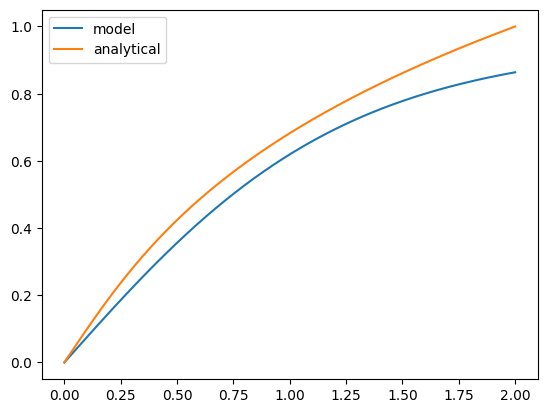

Epoch 600/3000, g: 0.00094691, InSamf: 0.21188393, OutSamf= 0.22170375
time elapsed: 239.0144500732422


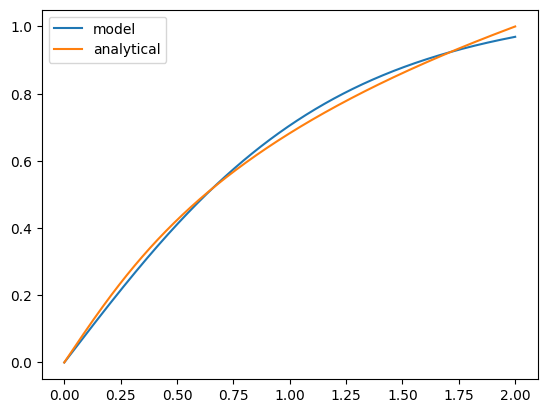

Epoch 900/3000, g: 0.00093527, InSamf: 0.20949484, OutSamf= 0.21973769
time elapsed: 355.0384829044342


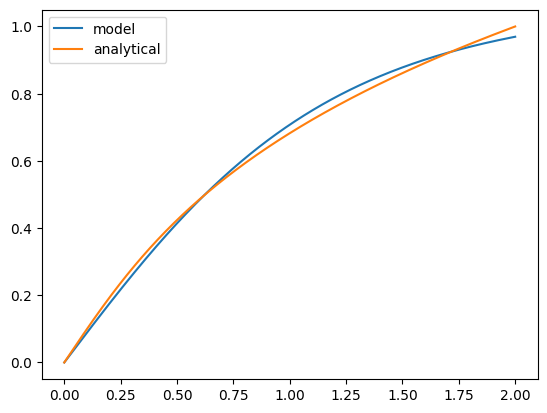

Epoch 1200/3000, g: 0.00092181, InSamf: 0.20679992, OutSamf= 0.21773766
time elapsed: 473.00874376296997


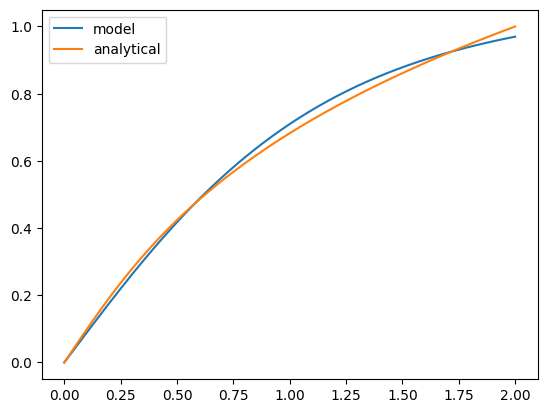

Epoch 1500/3000, g: 0.00090670, InSamf: 0.20387128, OutSamf= 0.21609887
time elapsed: 587.7678158283234


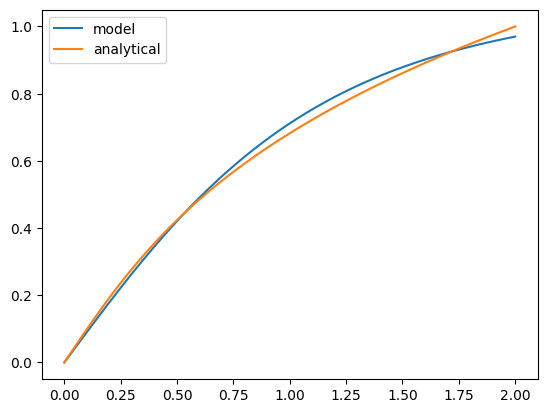

Epoch 1800/3000, g: 0.00089008, InSamf: 0.20074829, OutSamf= 0.21297058
time elapsed: 704.1734986305237


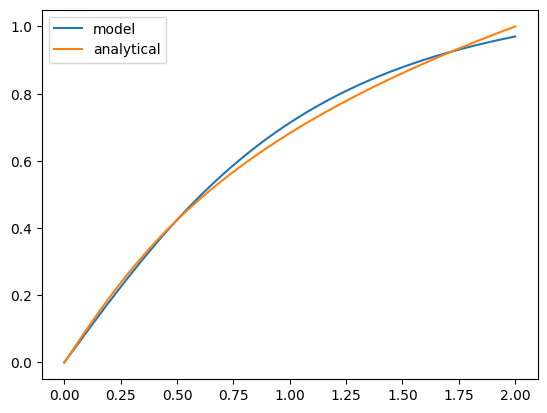

Epoch 2100/3000, g: 0.00087201, InSamf: 0.19745816, OutSamf= 0.2099317
time elapsed: 820.7471022605896


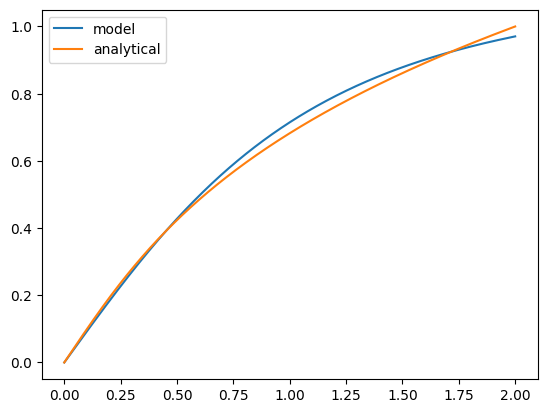

Epoch 2400/3000, g: 0.00085256, InSamf: 0.19403584, OutSamf= 0.20563394
time elapsed: 936.8822326660156


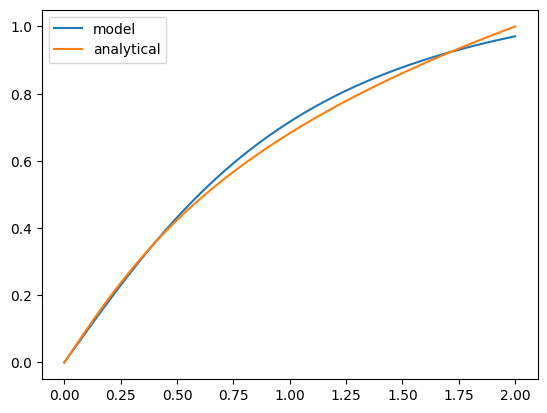

Epoch 2700/3000, g: 0.00083190, InSamf: 0.19054771, OutSamf= 0.20519192
time elapsed: 1053.1143822669983


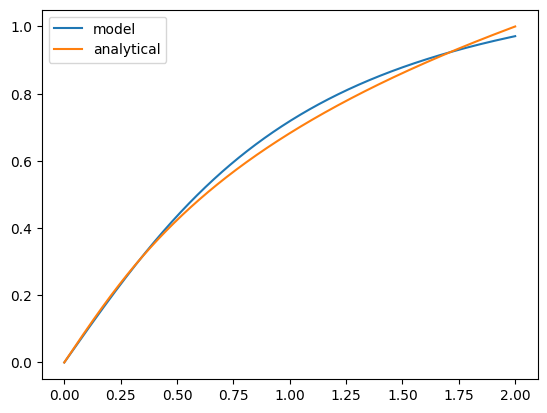

Epoch 3000/3000, g: 0.00081046, InSamf: 0.18711648, OutSamf= 0.20137205
time elapsed: 1169.6643207073212


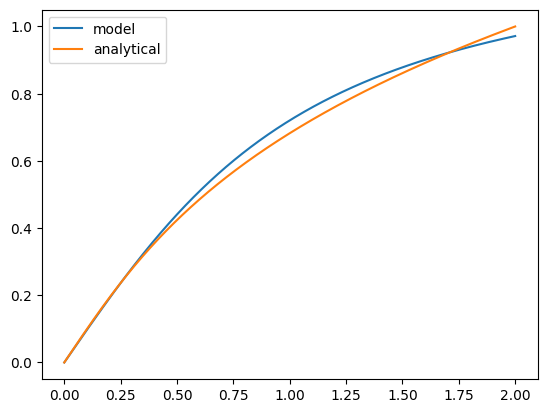

KeyboardInterrupt: 

In [11]:
model=burgerslf(N=5000)
model.Train()

In [6]:
#Make an NN (try #6: knowing lambda, penalize first deriv of residue)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class burgerslf(torch.nn.Module):
    def __init__(
        self,
        input_dim=1, #1, y(x and t)
        output_dim=1, #2, U and lambda
        N=100,
        l=0.5,
        epochs=3000,
        lr=1e-4,
    ):
        super().__init__()

        self.epochs = epochs
        self.lr = lr
        self.N = N
        self.l=l

        self.layers = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
        )
        self.out = nn.Linear(20, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)
        return out


    def Train(self):


        cpts=torch.sinh(2.0*torch.tensor([random.random() for i in range(5*self.N)], requires_grad=True))
        cpts=cpts.view(5*self.N, 1)

        start=time.time()
        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()


        def loss_g():
          U_2=(self.Model(torch.tensor([2.0]).view(1,1))[:,0] - self.Model(torch.tensor([-2.0]).view(1,1))[:,0])/2.0
          loss=(U_2-1.0)**2
          return loss.mean()

        def loss_f(input):
          U = (self.Model(input)[:,0] - self.Model(-1*input)[:,0])/2.0 #the odd part of the model
          #print('U shape{}'.format(U.shape))
          Uy=grad(U,input)[0].view(input.shape[0])
          #print('Uy shape{}'.format(Uy.shape))
          f1=-self.l*U #Model takes ([500,1])shape input #But this equation has to have input as a ([500]) vector
          f2=Uy*((1+self.l)*input.view(input.shape[0]) + U)
          f=f1+f2
          f=f**2 + 0.05*(Uy**2)
          return f.mean()

        loss=100
        lossout=10000
        ep=0

        while lossout>=loss:
          while loss>=1e-4:
            optimiser.zero_grad()

            lossg=loss_g()
            lossf=loss_f(cpts)
            loss = lossg + .1*lossf
            loss.backward(retain_graph=True) #this is Gemini suggestion
            optimiser.step()
            ep+=1

            if ep % int(self.epochs / 10) == 0:

              checkpts=torch.cat((torch.sinh(3.0*torch.tensor([random.random() for i in range(7*self.N)], requires_grad=True)), torch.sinh(5.0*torch.tensor([random.random() for i in range(3*self.N)], requires_grad=True))))
              checkpts=checkpts.view(10*self.N, 1)
              outofsamplelossf=loss_f(checkpts)
              lossout = lossg + .1*outofsamplelossf


              print(f"Epoch {ep}/{self.epochs}, g: {lossg:.8f}, InSamf: {lossf:.8f}, OutSamf= {outofsamplelossf:.8}")
              print('time elapsed: {}'.format(time.time()-start))
              U=np.linspace(0,1,1000)
              y=U + U**(1+1/0.5)
              U2=((self.Model(torch.tensor(y).view(1000,1))[:,0]-self.Model(-1*torch.tensor(y).view(1000,1))[:,0])/2.0).detach().numpy()
              plt.plot(y, U2, label='model')
              plt.plot(y,U, label='analytical')
              plt.legend()
              plt.show()

            #save the model
            #https://www.tensorflow.org/tutorials/keras/save_and_load

        return ()

    def Model(self, X):
        self.eval()
        out = self.forward(X)
        return out #.detach().cpu().numpy()

Epoch 300/3000, g: 0.03049697, InSamf: 0.13249450, OutSamf= 0.15546271
time elapsed: 49.54629039764404


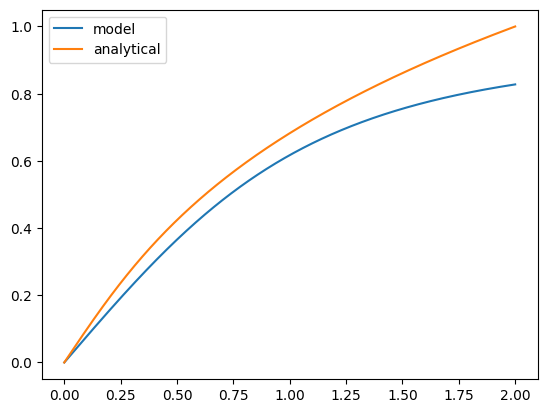

Epoch 600/3000, g: 0.00090437, InSamf: 0.20364429, OutSamf= 0.22446
time elapsed: 101.52616691589355


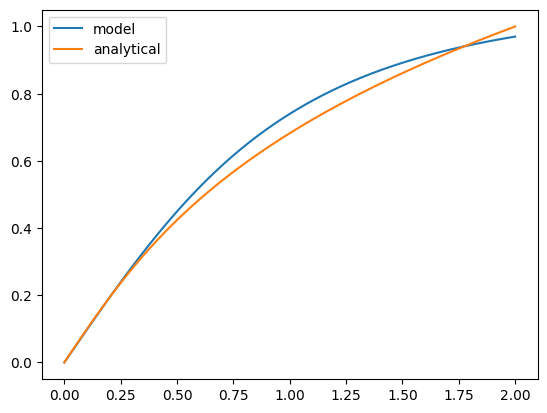

Epoch 900/3000, g: 0.00088259, InSamf: 0.20022825, OutSamf= 0.22167366
time elapsed: 151.53803133964539


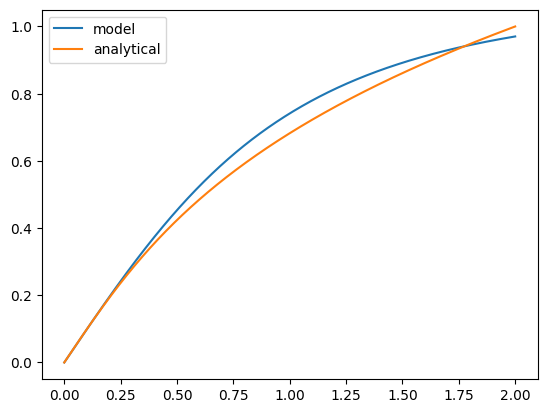

Epoch 1200/3000, g: 0.00086326, InSamf: 0.19691381, OutSamf= 0.2184535
time elapsed: 198.9116175174713


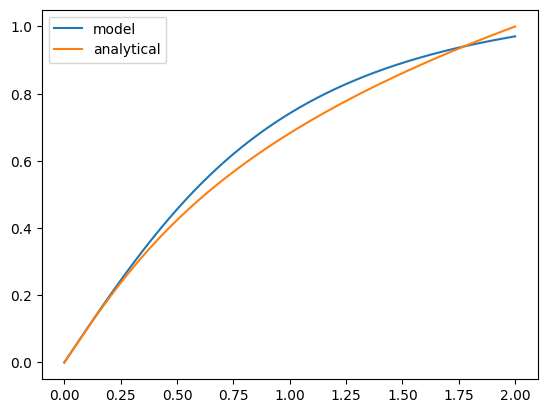

Epoch 1500/3000, g: 0.00084286, InSamf: 0.19344213, OutSamf= 0.21629534
time elapsed: 249.50022625923157


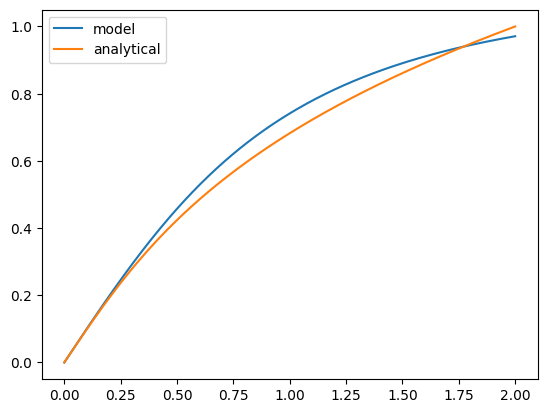

Epoch 1800/3000, g: 0.00082025, InSamf: 0.18938113, OutSamf= 0.21280172
time elapsed: 298.3297848701477


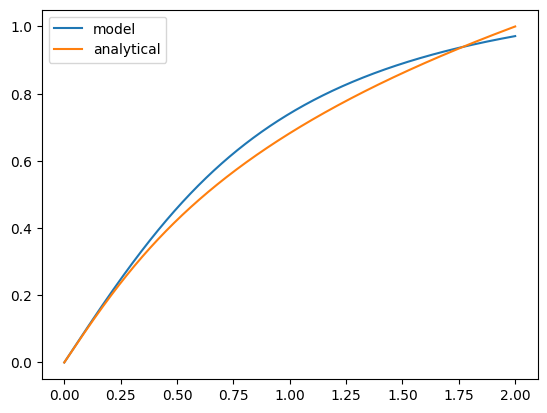

Epoch 2100/3000, g: 0.00079376, InSamf: 0.18426597, OutSamf= 0.20968367
time elapsed: 345.17262268066406


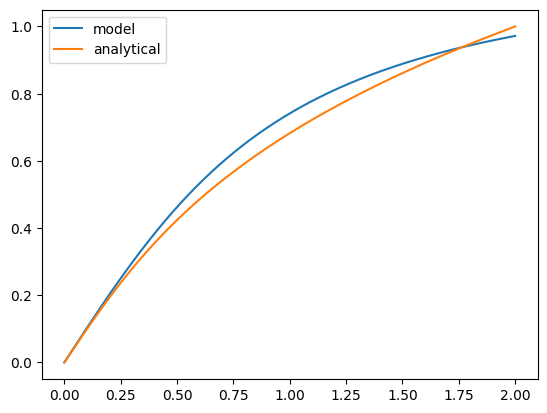

Epoch 2400/3000, g: 0.00076017, InSamf: 0.17780479, OutSamf= 0.20503584
time elapsed: 393.1979238986969


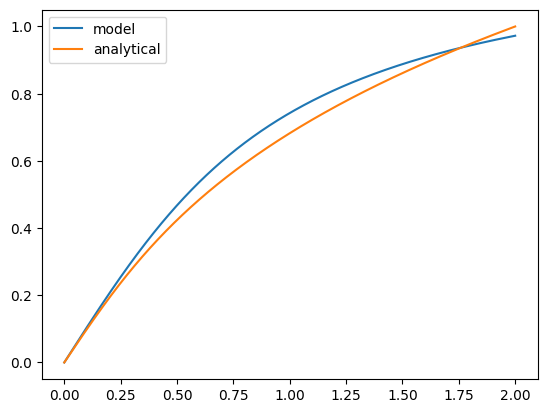

Epoch 2700/3000, g: 0.00071657, InSamf: 0.17027958, OutSamf= 0.19923944
time elapsed: 439.9534947872162


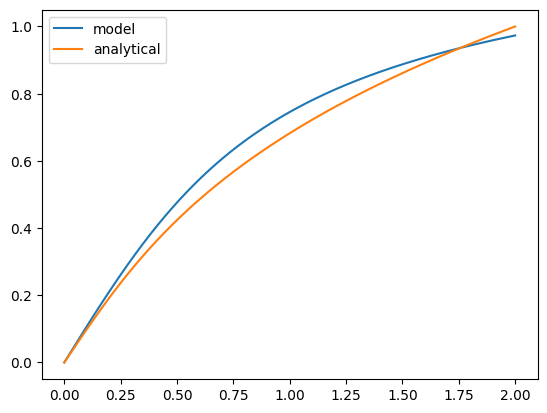

Epoch 3000/3000, g: 0.00066762, InSamf: 0.16263106, OutSamf= 0.1941342
time elapsed: 488.85071206092834


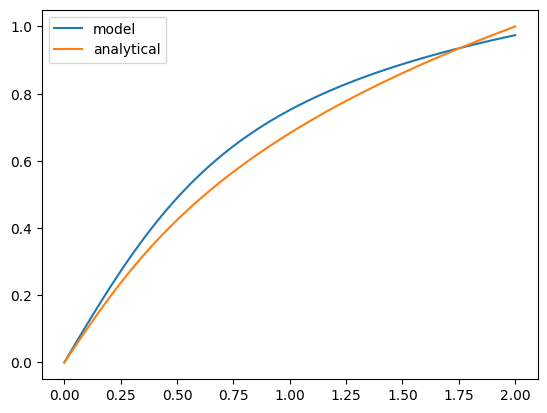

Epoch 3300/3000, g: 0.00062207, InSamf: 0.15572448, OutSamf= 0.19043732
time elapsed: 535.6054358482361


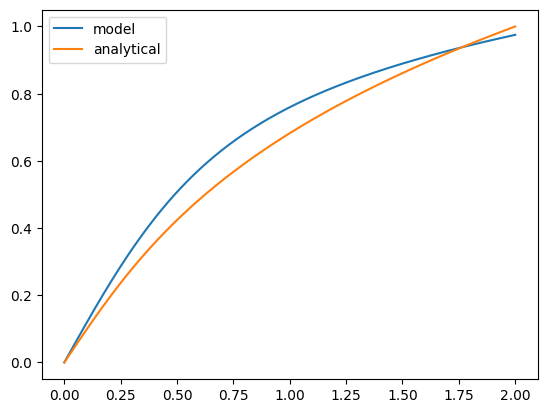

Epoch 3600/3000, g: 0.00058324, InSamf: 0.14965531, OutSamf= 0.18576036
time elapsed: 583.4414522647858


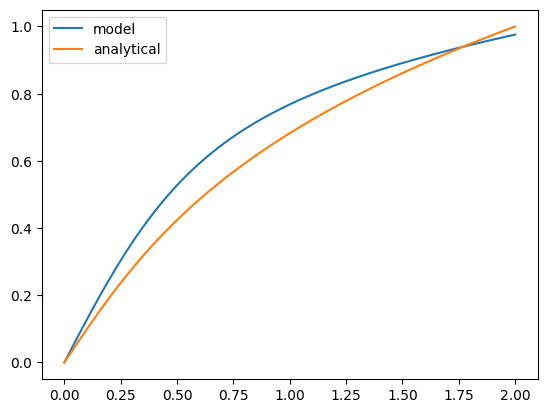

Epoch 3900/3000, g: 0.00054915, InSamf: 0.14391918, OutSamf= 0.18479078
time elapsed: 630.065505027771


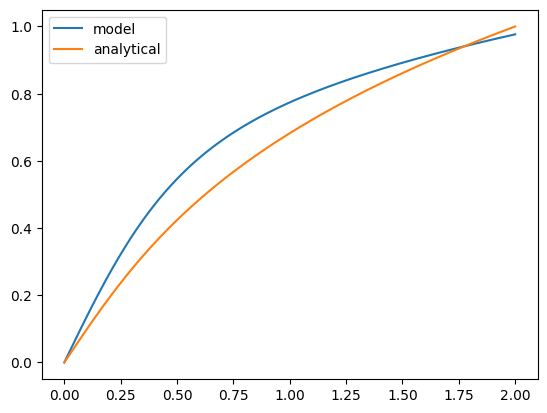

Epoch 4200/3000, g: 0.00051539, InSamf: 0.13790968, OutSamf= 0.18147983
time elapsed: 679.3281738758087


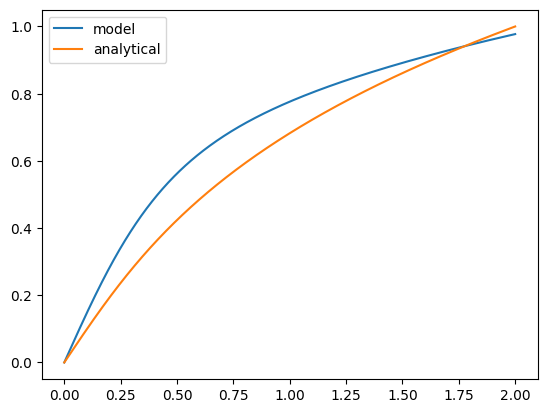

Epoch 4500/3000, g: 0.00047739, InSamf: 0.13151667, OutSamf= 0.17802447
time elapsed: 727.2870697975159


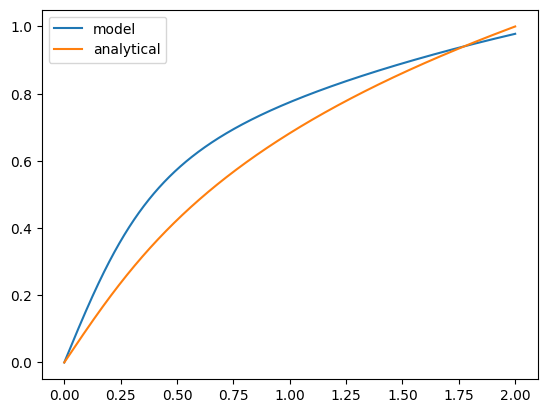

Epoch 4800/3000, g: 0.00043913, InSamf: 0.12551754, OutSamf= 0.17317914
time elapsed: 776.0797927379608


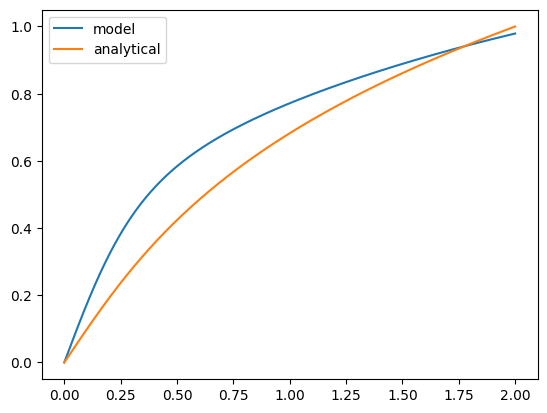

Epoch 5100/3000, g: 0.00040687, InSamf: 0.12068649, OutSamf= 0.17209684
time elapsed: 826.017240524292


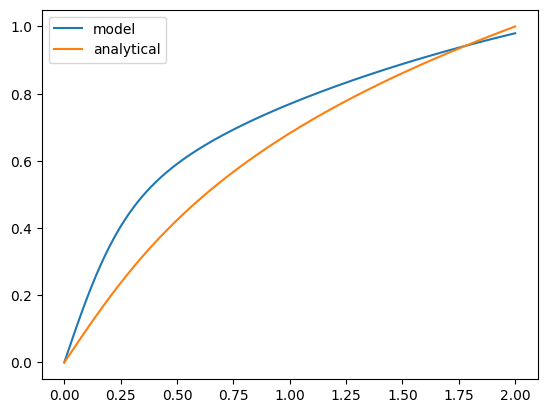

KeyboardInterrupt: 

In [7]:
model=burgerslf(N=5000)
model.Train()

In [33]:
#Make an NN (try #5.1: knowing lambda)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class burgersl(torch.nn.Module):
    def __init__(
        self,
        input_dim=1, #1, y(x and t)
        output_dim=1, #2, U and lambda
        N=100,
        l=0.5,
        epochs=3000,
        lr=1e-4,
    ):
        super().__init__()

        self.epochs = epochs
        self.lr = lr
        self.N = N
        self.l=l

        self.layers = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
        )
        self.out = nn.Linear(20, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)
        return out


    def Train(self):

        cpts=2.0*torch.tensor([random.random() for i in range(5*self.N)], requires_grad=True)
        cpts=cpts.view(5*self.N, 1)

        start=time.time()
        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()


        def loss_g():
          U_2=(self.Model(torch.tensor([-2.0]).view(1,1))[:,0] - self.Model(torch.tensor([2.0]).view(1,1))[:,0])/2.0
          loss=(U_2-1.0)**2
          return loss

        def loss_f(input):
          U = (self.Model(input)[:,0] - self.Model(-1*input)[:,0])/2.0 #the odd part of the model
          #print('U shape{}'.format(U.shape))
          Uy=grad(U,input)[0].view(input.shape[0])
          #print('Uy shape{}'.format(Uy.shape))
          f1=-self.l*U #Model takes ([500,1])shape input #But this equation has to have input as a ([500]) vector
          f2=Uy*((1+self.l)*input.view(input.shape[0]) + U)
          f=f1+f2
          f=f**2
          return f.mean()

        loss=1000
        lossout=10000
        ep=0

        while lossout>=loss:
          while loss>=1e-4:
            optimiser.zero_grad()

            cpts=2.0*torch.tensor([random.random() for i in range(5*self.N)], requires_grad=True)
            cpts=cpts.view(5*self.N, 1)


            lossg=loss_g()
            lossf=loss_f(cpts)

            loss = lossg + .1*lossf

            loss.backward()
            optimiser.step()
            ep+=1


            if ep % int(self.epochs / 10) == 0:

              checkpts=torch.cat((torch.sinh(3.0*torch.tensor([random.random() for i in range(7*self.N)], requires_grad=True)), torch.sinh(5.0*torch.tensor([random.random() for i in range(3*self.N)], requires_grad=True))))
              checkpts=checkpts.view(10*self.N, 1)

              #outofsamplelossf=loss_f(checkpts)

              #lossout = lossg + .1*outofsamplelossf

              print(f"Epoch {ep}/{self.epochs}, g: {lossg}, InSamf: {lossf:.8f}")
              print('time elapsed: {}'.format(time.time()-start))
              U=np.linspace(0,1,1000)
              y=(U + U**(1+1/0.5))*-1.0
              U2=((self.Model(torch.tensor(y).view(1000,1))[:,0]-self.Model(-1*torch.tensor(y).view(1000,1))[:,0])/2.0).detach().numpy()
              plt.plot(y, U2, label='model')
              plt.plot(y,U, label='analytical')
              plt.legend()
              plt.show()

            #save the model
            #https://www.tensorflow.org/tutorials/keras/save_and_load

        return ()

    def Model(self, X):
        self.eval()
        out = self.forward(X)
        return out #.detach().cpu().numpy()

Epoch 300/3000, g: tensor([0.0064], grad_fn=<PowBackward0>), InSamf: 0.01398364
time elapsed: 11.181765079498291


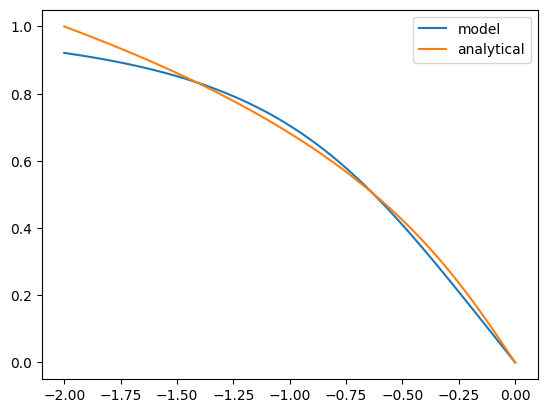

Epoch 600/3000, g: tensor([1.8239e-05], grad_fn=<PowBackward0>), InSamf: 0.01737923
time elapsed: 22.348921298980713


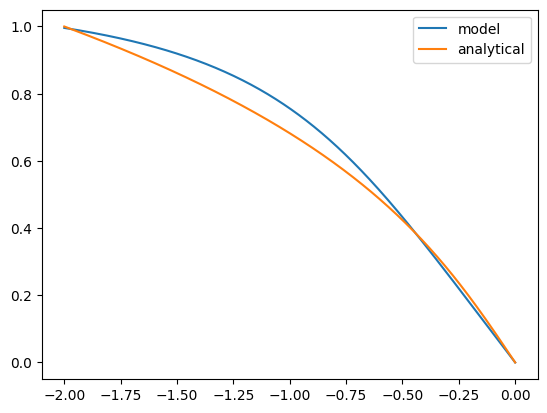

Epoch 900/3000, g: tensor([1.1556e-05], grad_fn=<PowBackward0>), InSamf: 0.01465662
time elapsed: 32.75605297088623


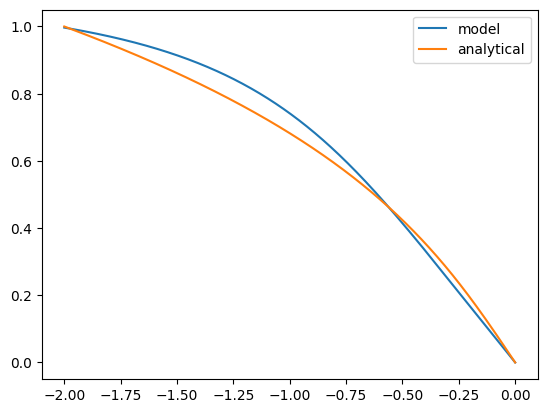

Epoch 1200/3000, g: tensor([6.7211e-06], grad_fn=<PowBackward0>), InSamf: 0.01197803
time elapsed: 44.16301465034485


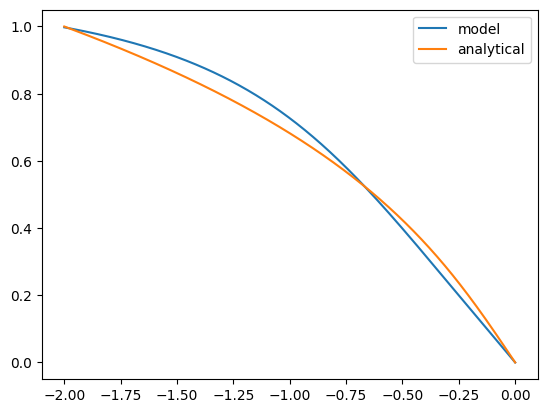

Epoch 1500/3000, g: tensor([3.7270e-06], grad_fn=<PowBackward0>), InSamf: 0.01047947
time elapsed: 55.4218225479126


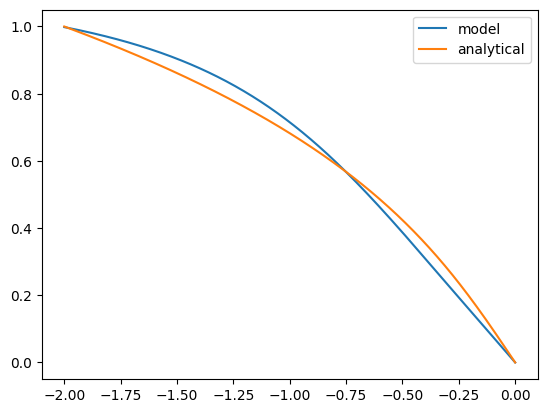

Epoch 1800/3000, g: tensor([2.1755e-06], grad_fn=<PowBackward0>), InSamf: 0.00957830
time elapsed: 66.66128277778625


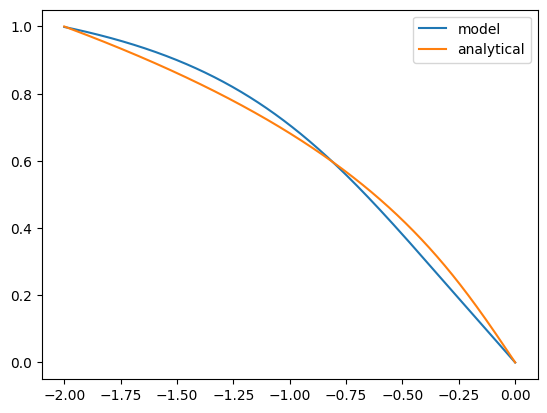

Epoch 2100/3000, g: tensor([1.2769e-06], grad_fn=<PowBackward0>), InSamf: 0.00833870
time elapsed: 78.17070269584656


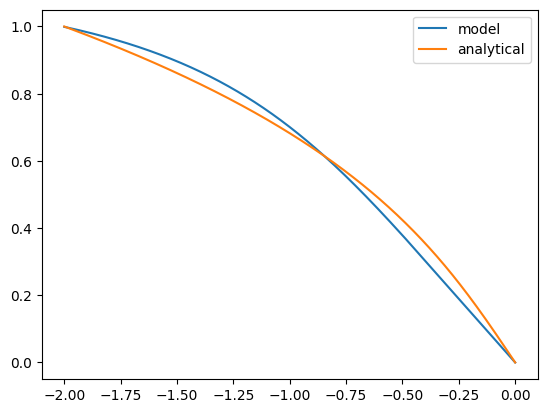

Epoch 2400/3000, g: tensor([8.1379e-07], grad_fn=<PowBackward0>), InSamf: 0.00741033
time elapsed: 89.24377608299255


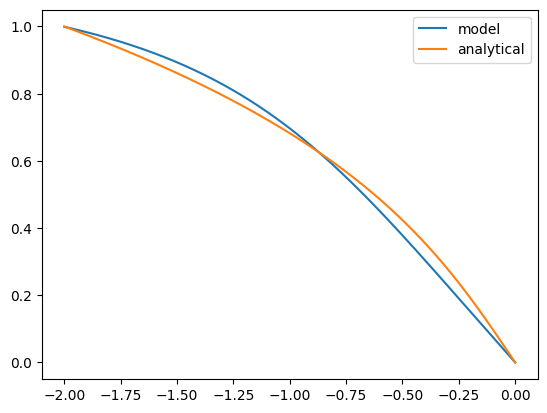

Epoch 2700/3000, g: tensor([5.4913e-07], grad_fn=<PowBackward0>), InSamf: 0.00645412
time elapsed: 100.36976361274719


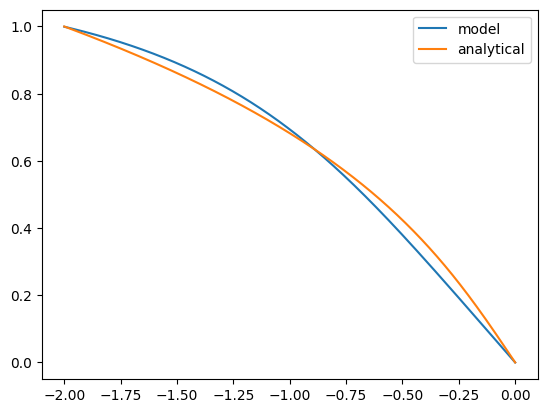

Epoch 3000/3000, g: tensor([3.6011e-07], grad_fn=<PowBackward0>), InSamf: 0.00565779
time elapsed: 111.70546340942383


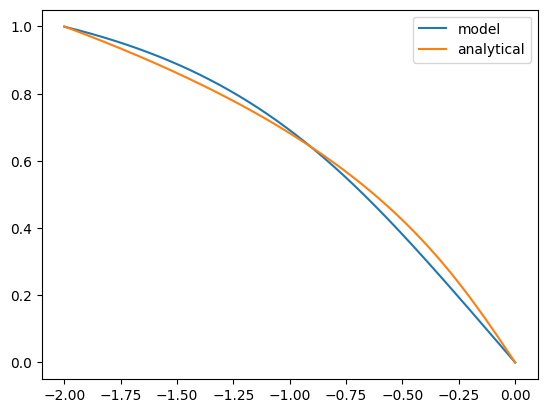

Epoch 3300/3000, g: tensor([2.2315e-07], grad_fn=<PowBackward0>), InSamf: 0.00473513
time elapsed: 124.0817928314209


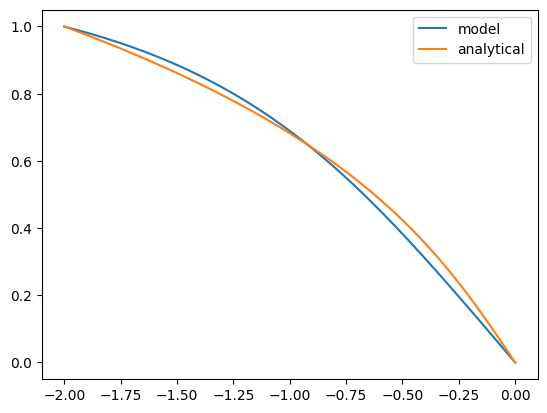

Epoch 3600/3000, g: tensor([1.2221e-07], grad_fn=<PowBackward0>), InSamf: 0.00418762
time elapsed: 137.04464435577393


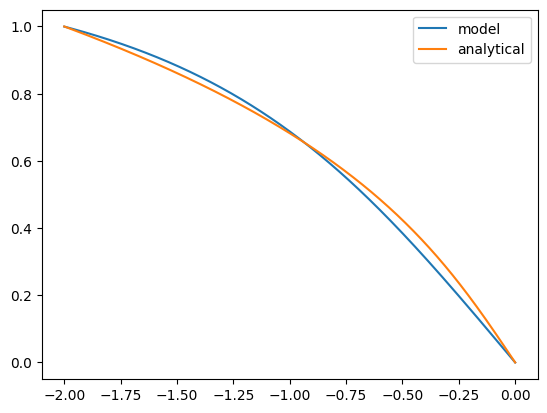

Epoch 3900/3000, g: tensor([7.7266e-08], grad_fn=<PowBackward0>), InSamf: 0.00352875
time elapsed: 149.28079986572266


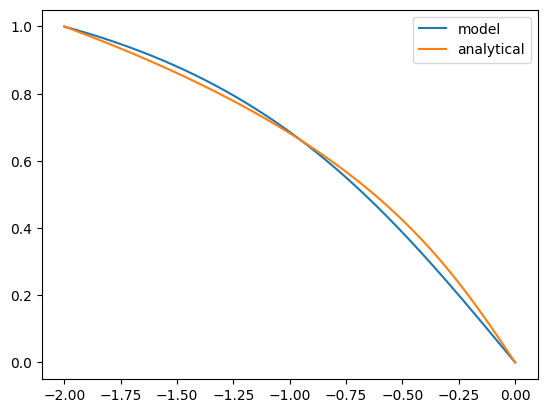

Epoch 4200/3000, g: tensor([3.4003e-08], grad_fn=<PowBackward0>), InSamf: 0.00294255
time elapsed: 160.72078108787537


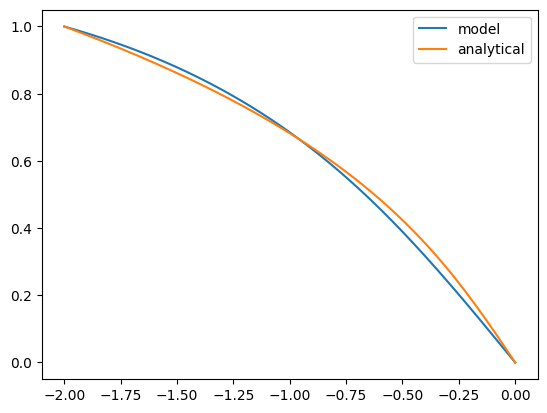

Epoch 4500/3000, g: tensor([8.6685e-09], grad_fn=<PowBackward0>), InSamf: 0.00233918
time elapsed: 172.0559310913086


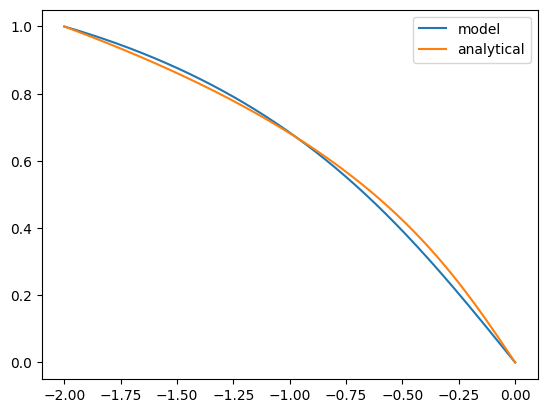

Epoch 4800/3000, g: tensor([1.0585e-09], grad_fn=<PowBackward0>), InSamf: 0.00192102
time elapsed: 184.59416675567627


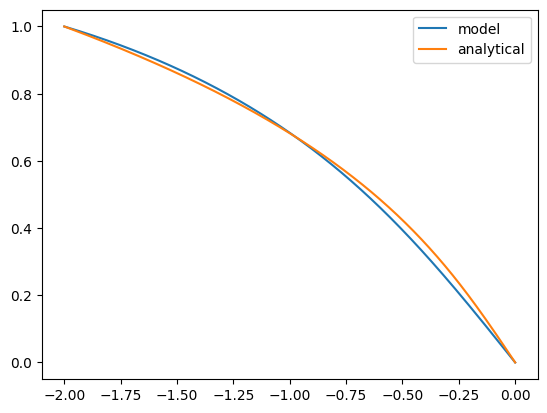

Epoch 5100/3000, g: tensor([6.0810e-12], grad_fn=<PowBackward0>), InSamf: 0.00149885
time elapsed: 195.13256311416626


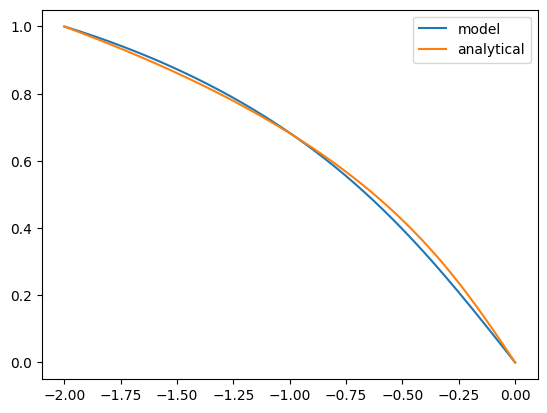

Epoch 5400/3000, g: tensor([1.7424e-09], grad_fn=<PowBackward0>), InSamf: 0.00117191
time elapsed: 206.27162098884583


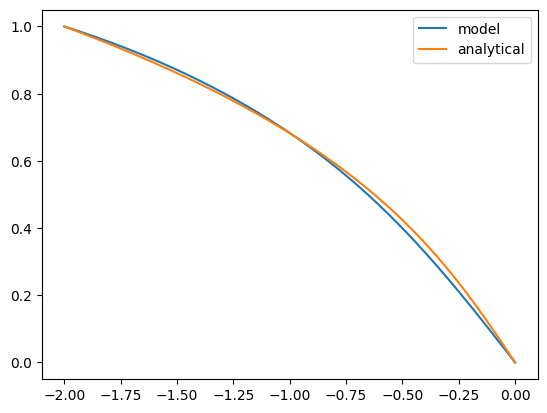

KeyboardInterrupt: 

In [34]:
model=burgersl(N=1000)
model.Train()

In [ ]:
#Make an NN (try #5: knowing lambda)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class burgersl(torch.nn.Module):
    def __init__(
        self,
        input_dim=1, #1, y(x and t)
        output_dim=1, #2, U and lambda
        N=100,
        l=0.5,
        epochs=3000,
        lr=1e-4,
    ):
        super().__init__()

        self.epochs = epochs
        self.lr = lr
        self.N = N
        self.l=l

        self.layers = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
        )
        self.out = nn.Linear(20, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)
        return out


    def Train(self):

        #for cpts use y=sinh(random), as tristan paper
        cpts=torch.sinh(2.0*torch.tensor([random.random() for i in range(5*self.N)], requires_grad=True))
        cpts=cpts.view(5*self.N, 1)

        start=time.time()
        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()


        def loss_g():
          U_2=(self.Model(torch.tensor([2.0]).view(1,1))[:,0] - self.Model(torch.tensor([-2.0]).view(1,1))[:,0])/2.0
          loss=(U_2-1.0)**2
          return loss.mean()

        def loss_f(input):
          U = (self.Model(input)[:,0] - self.Model(-1*input)[:,0])/2.0 #the odd part of the model
          #print('U shape{}'.format(U.shape))
          Uy=grad(U,input)[0].view(input.shape[0])
          #print('Uy shape{}'.format(Uy.shape))
          f1=-self.l*U #Model takes ([500,1])shape input #But this equation has to have input as a ([500]) vector
          f2=Uy*((1+self.l)*input.view(input.shape[0]) + U)
          f=f1+f2
          f=f**2
          return f.mean()

        loss=1000
        lossout=10000
        ep=0

        while lossout>=loss:
          while loss>=1e-4:
            optimiser.zero_grad()


            lossg=loss_g()
            lossf=loss_f(cpts)

            loss = lossg + .1*lossf

            loss.backward(retain_graph=True) #this is Gemini suggestion
            optimiser.step()
            ep+=1



            if ep % int(self.epochs / 10) == 0:

              checkpts=torch.cat((torch.sinh(3.0*torch.tensor([random.random() for i in range(7*self.N)], requires_grad=True)), torch.sinh(5.0*torch.tensor([random.random() for i in range(3*self.N)], requires_grad=True))))
              checkpts=checkpts.view(10*self.N, 1)

              outofsamplelossf=loss_f(checkpts)

              lossout = lossg + .1*outofsamplelossf




              print(f"Epoch {ep}/{self.epochs}, g: {lossg:.8f}, InSamf: {lossf:.8f}, OutSamf= {outofsamplelossf:.8}")
              print('time elapsed: {}'.format(time.time()-start))
              U=np.linspace(0,1,1000)
              y=U + U**(1+1/0.5)
              U2=((self.Model(torch.tensor(y).view(1000,1))[:,0]-self.Model(-1*torch.tensor(y).view(1000,1))[:,0])/2.0).detach().numpy()
              plt.plot(y, U2, label='model')
              plt.plot(y,U, label='analytical')
              plt.legend()
              plt.show()

            #save the model
            #https://www.tensorflow.org/tutorials/keras/save_and_load

        return ()

    def Model(self, X):
        self.eval()
        out = self.forward(X)
        return out #.detach().cpu().numpy()

In [22]:
modell=burgersl(N=5000)
modell.Train()

Output hidden; open in https://colab.research.google.com to view.

In [59]:
#Make an NN (try #4)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#tristan
#lam_init + epsilon * sin (aux_lam)


class burgers(torch.nn.Module):
    def __init__(
        self,
        input_dim=1, #1, y(x and t)
        output_dim=1, #2, U and lambda
        N=100,
        epochs=3000,
        lr=1e-4,
        laminit=0.45

    ):
        super().__init__()

        self.epochs = epochs
        self.lr = lr
        self.N = N
        self.laminit=laminit
        self.auxlamda = torch.nn.Parameter(0.1*torch.randn(1))
        self.auxlamda.requires_grad = True

        self.layers = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
        )
        self.out = nn.Linear(20, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)
        return out


    def Train(self):

        start=time.time()
        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()


        def loss_g():
          U_2=(self.Model(torch.tensor([-2.0]).view(1,1))[:,0] - self.Model(torch.tensor([2.0]).view(1,1))[:,0])/2.0
          loss=(U_2-1.0)**2
          return loss

        def loss_f(input, lamda):
          U = (self.Model(input)[:,0] - self.Model(-1*input)[:,0])/2.0 #the odd part of the model
          Uy=grad(U,input)[0].view(input.shape[0])
          f1=-lamda*U
          f2=Uy*((1+lamda)*input.view(input.shape[0]) + U)
          f=f1+f2
          f=f**2
          return f.mean()

        loss=100
        lossout=10000
        ep=0

        while lossout>=20*loss:
          while loss>=1e-4:
            optimiser.zero_grad()

            cpts=2.0*torch.tensor([random.random() for i in range(5*self.N)], requires_grad=True)
            cpts=cpts.view(5*self.N, 1)

            lamda = self.laminit+0.5*torch.sin(self.auxlamda)
            #print(lamda.shape)

            lossg=loss_g()
            lossf=loss_f(cpts, lamda)
            loss = lossg + .1*lossf
            loss.backward()
            optimiser.step()
            ep+=1


            if ep % int(self.epochs / 10) == 0:

              # checkpts=torch.cat((torch.sinh(3.0*torch.tensor([random.random() for i in range(7*self.N)], requires_grad=True)), torch.sinh(5.0*torch.tensor([random.random() for i in range(3*self.N)], requires_grad=True))))
              # checkpts=checkpts.view(10*self.N, 1)
              # outofsamplelossf=loss_f(checkpts, lamda)
              print(f"Epoch {ep}/{self.epochs}, g: {lossg.item():.8f}, f: {lossf:.8f},Lambda={lamda.item():.5f}")
              print('time elapsed: {}'.format(time.time()-start))

              U=np.linspace(0,1,1000)
              y=(U + U**(1+1/0.5))*-1.0
              U2=((self.Model(torch.tensor(y).view(1000,1))[:,0]-self.Model(-1*torch.tensor(y).view(1000,1))[:,0])/2.0).detach().numpy()
              plt.plot(y, U2, label='model')
              plt.plot(y,U, label='analytical')
              plt.legend()
              plt.show()

            #save the model
            #https://www.tensorflow.org/tutorials/keras/save_and_load

        return ()

    def Model(self, X):
        self.eval()
        out = self.forward(X)
        return out #.detach().cpu().numpy()

Epoch 300/3000, g: 0.01694126, f: 0.01017123,Lambda=0.42364
time elapsed: 5.7681005001068115


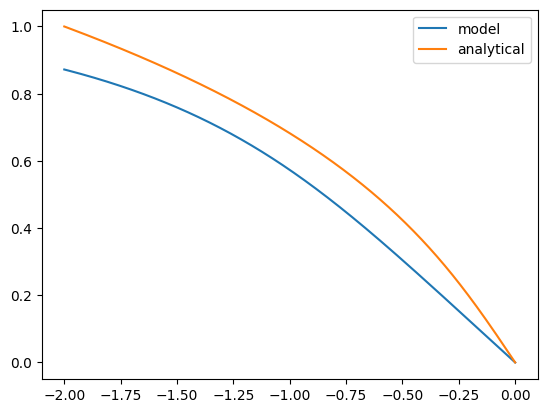

Epoch 600/3000, g: 0.00000101, f: 0.00518906,Lambda=0.42867
time elapsed: 12.864123821258545


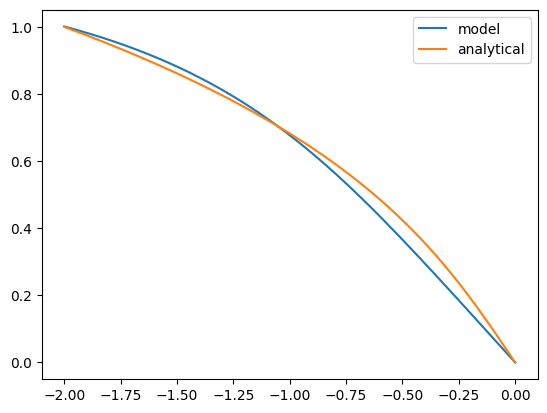

Epoch 900/3000, g: 0.00000061, f: 0.00452820,Lambda=0.42602
time elapsed: 18.846859455108643


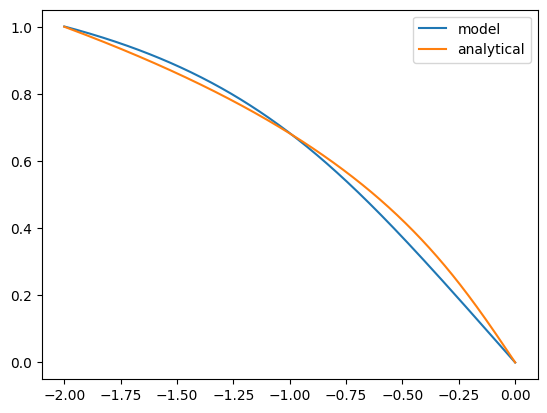

Epoch 1200/3000, g: 0.00000039, f: 0.00397253,Lambda=0.41849
time elapsed: 26.54332661628723


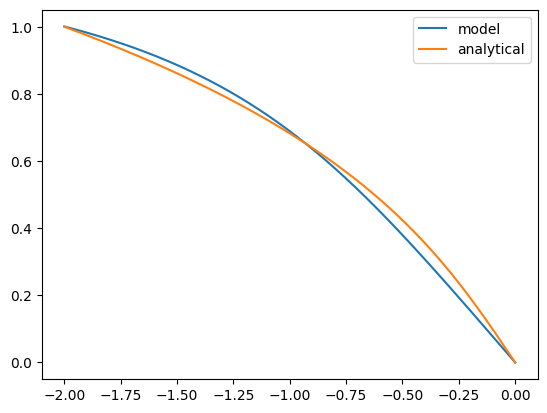

Epoch 1500/3000, g: 0.00000029, f: 0.00330165,Lambda=0.40737
time elapsed: 32.48852276802063


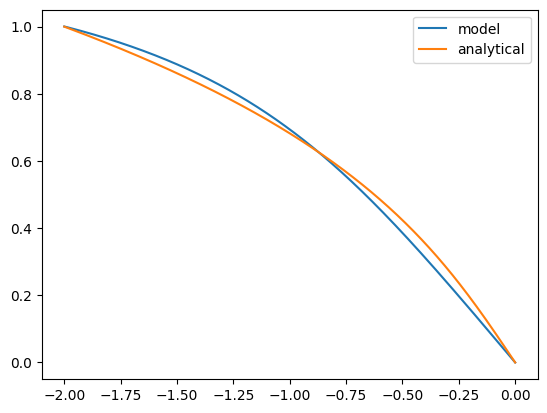

Epoch 1800/3000, g: 0.00000024, f: 0.00295648,Lambda=0.39472
time elapsed: 40.131927728652954


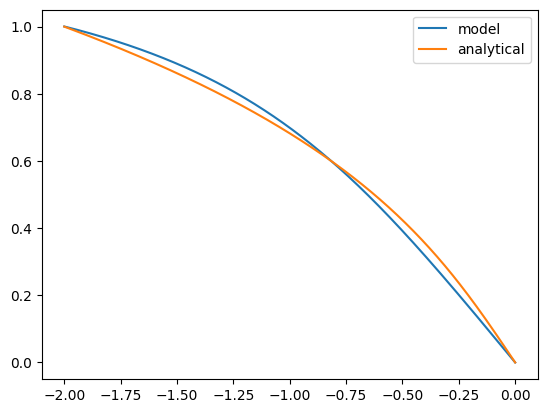

Epoch 2100/3000, g: 0.00000021, f: 0.00254376,Lambda=0.38168
time elapsed: 46.364381313323975


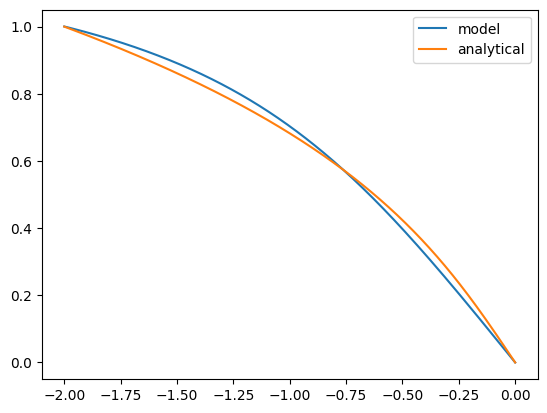

Epoch 2400/3000, g: 0.00000021, f: 0.00225752,Lambda=0.36883
time elapsed: 53.397868156433105


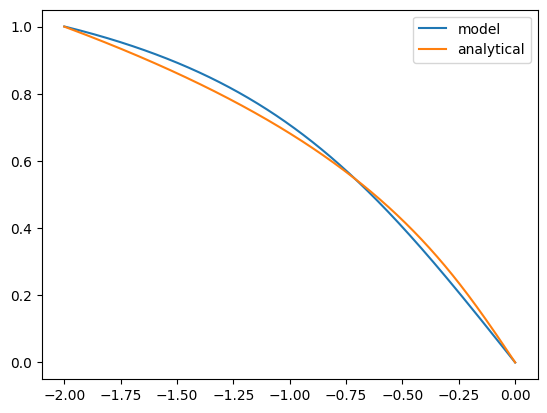

Epoch 2700/3000, g: 0.00000019, f: 0.00189810,Lambda=0.35664
time elapsed: 59.58132266998291


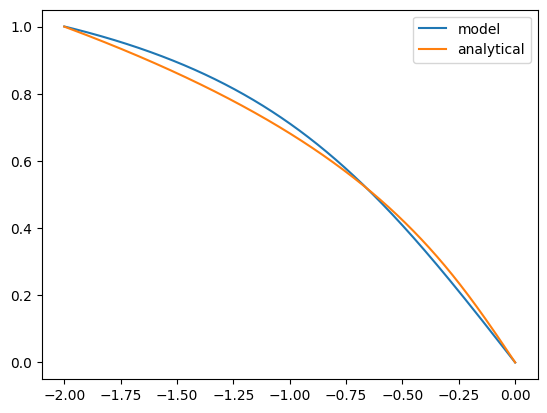

Epoch 3000/3000, g: 0.00000017, f: 0.00166333,Lambda=0.34503
time elapsed: 66.55541038513184


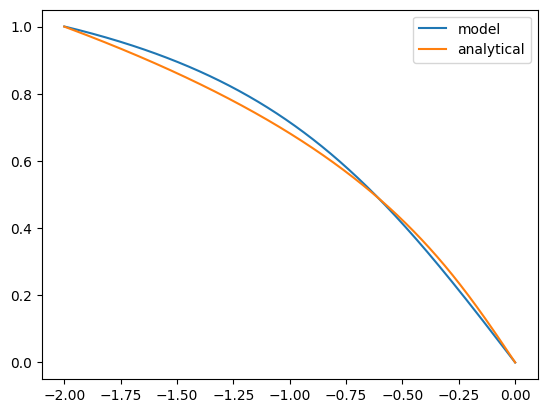

Epoch 3300/3000, g: 0.00000017, f: 0.00141492,Lambda=0.33391
time elapsed: 72.6026656627655


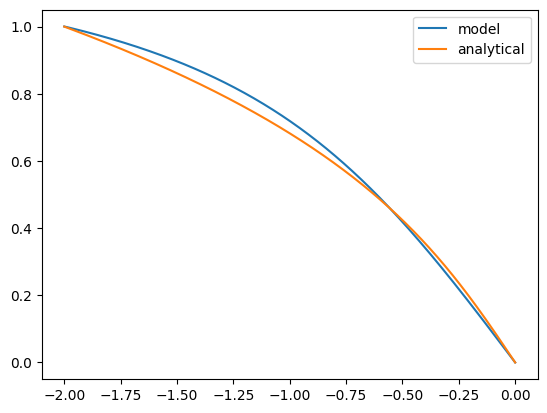

Epoch 3600/3000, g: 0.00000015, f: 0.00114202,Lambda=0.32341
time elapsed: 79.72233319282532


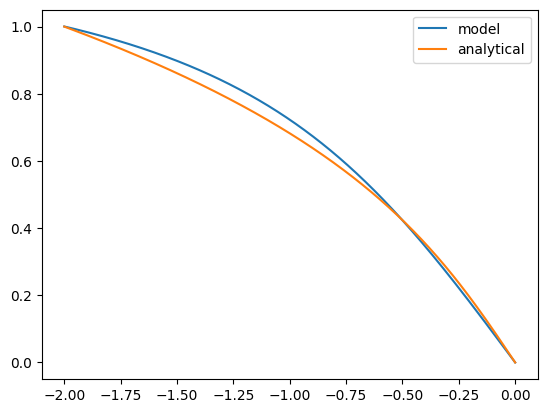

In [ ]:
model=burgers(N=500)
model.Train()

In [ ]:
torch.save(model.state_dict(), '1DSSBurgers0814.pt') #https://pytorch.org/tutorials/beginner/saving_loading_models.html#warmstarting-model-using-parameters-from-a-different-model

In [9]:
newmodel=burgers(1,2, N=5000) #https://pytorch.org/tutorials/beginner/saving_loading_models.html#warmstarting-model-using-parameters-from-a-different-model
newmodel.load_state_dict(torch.load('1DSSBurgers0814.pt'))

<All keys matched successfully>

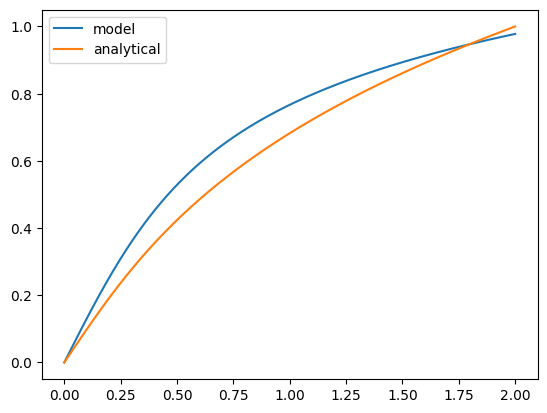

In [15]:
U=np.linspace(0,1,1000)
y=U + U**(1+1/0.5)
U2=((newmodel.Model(torch.tensor(y).view(1000,1))[:,0]-newmodel.Model(-1*torch.tensor(y).view(1000,1))[:,0])/2.0).detach().numpy()
plt.plot(y, U2, label='model')
plt.plot(y,U, label='analytical')
plt.legend()
plt.show()

Epoch 300/3000, loss_g: 0.05273228, loss_f: 0.21972081, lambda=0.208
time elapsed: 81.88251280784607


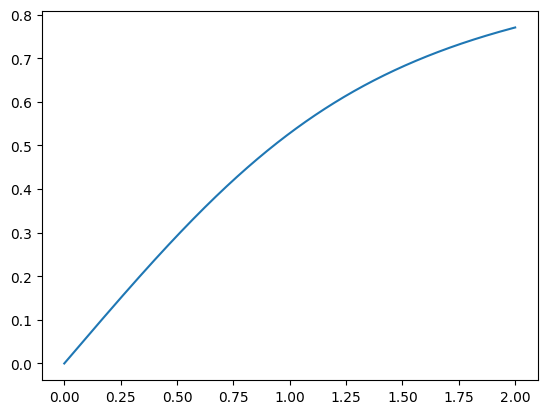

Epoch 600/3000, loss_g: 0.00089172, loss_f: 0.20308140, lambda=0.445
time elapsed: 160.2500023841858


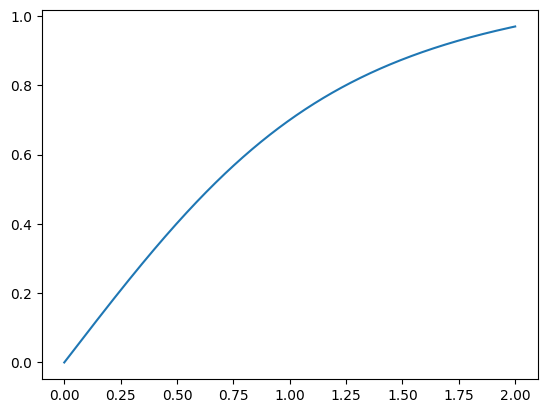

Epoch 900/3000, loss_g: 0.00080278, loss_f: 0.19264592, lambda=0.511
time elapsed: 240.80715894699097


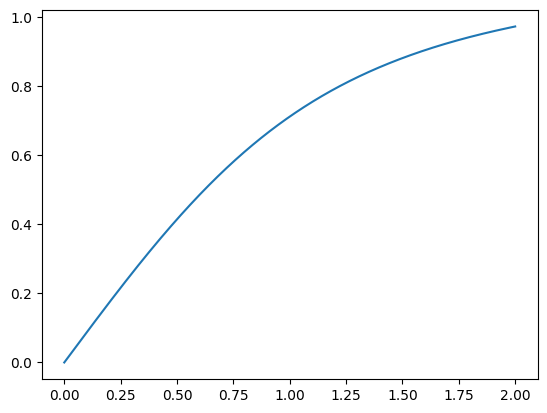

Epoch 1200/3000, loss_g: 0.00078224, loss_f: 0.18844249, lambda=0.516
time elapsed: 321.13224148750305


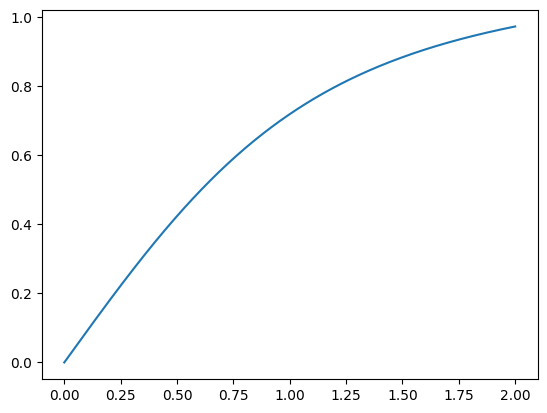

Epoch 1500/3000, loss_g: 0.00076314, loss_f: 0.18420080, lambda=0.516
time elapsed: 400.0446901321411


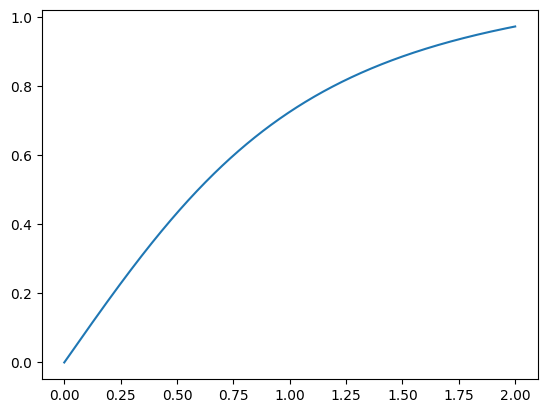

Epoch 1800/3000, loss_g: 0.00074308, loss_f: 0.17985047, lambda=0.516
time elapsed: 481.23502492904663


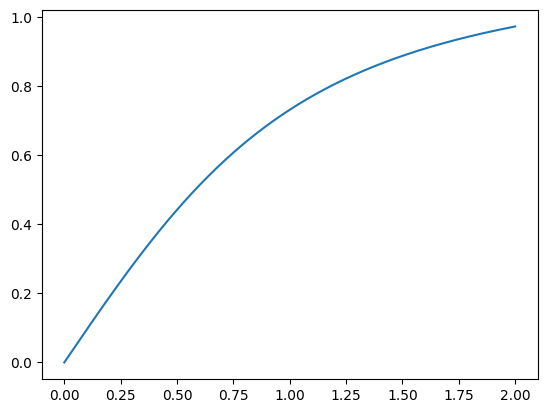

Epoch 2100/3000, loss_g: 0.00072136, loss_f: 0.17529659, lambda=0.516
time elapsed: 559.8987121582031


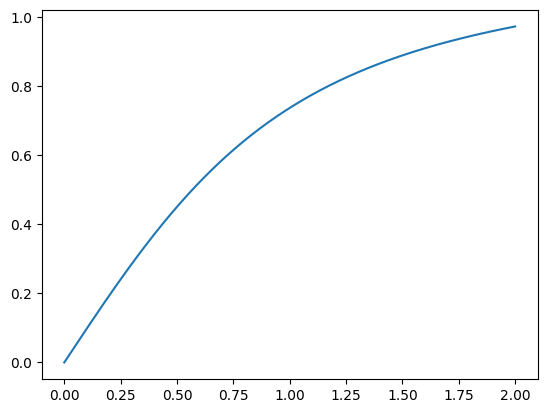

Epoch 2400/3000, loss_g: 0.00069708, loss_f: 0.17038806, lambda=0.518
time elapsed: 623.8766496181488


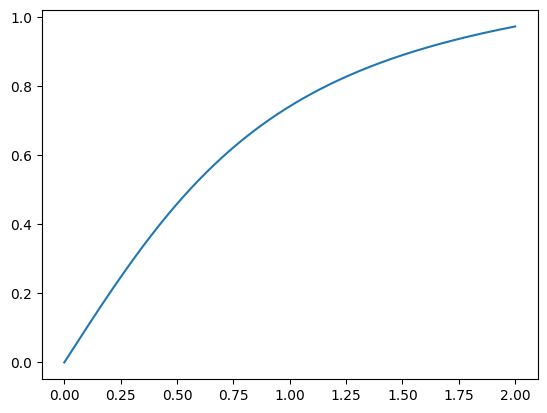

Epoch 2700/3000, loss_g: 0.00066911, loss_f: 0.16491977, lambda=0.521
time elapsed: 686.7744507789612


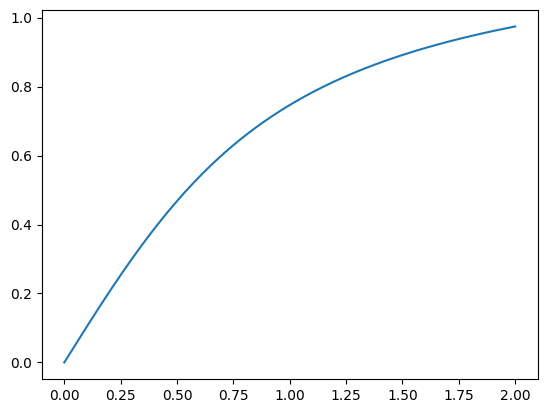

Epoch 3000/3000, loss_g: 0.00063613, loss_f: 0.15863480, lambda=0.525
time elapsed: 750.6426403522491


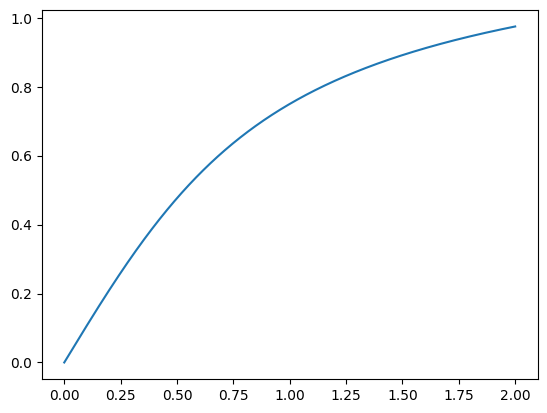

Epoch 3300/3000, loss_g: 0.00059681, loss_f: 0.15126002, lambda=0.532
time elapsed: 814.5650942325592


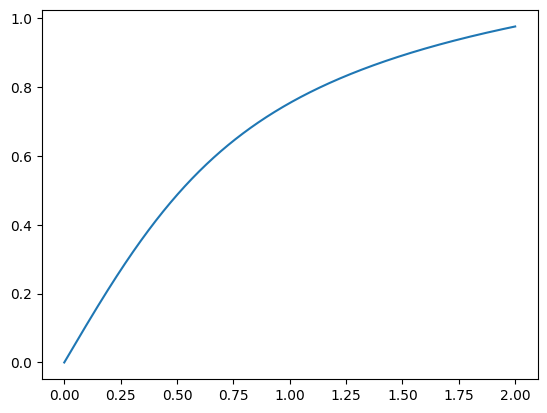

Epoch 3600/3000, loss_g: 0.00055007, loss_f: 0.14266261, lambda=0.54
time elapsed: 883.6601486206055


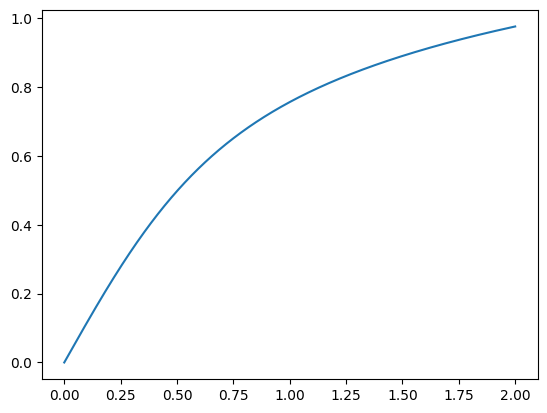

Epoch 3900/3000, loss_g: 0.00049628, loss_f: 0.13322017, lambda=0.55
time elapsed: 957.5891942977905


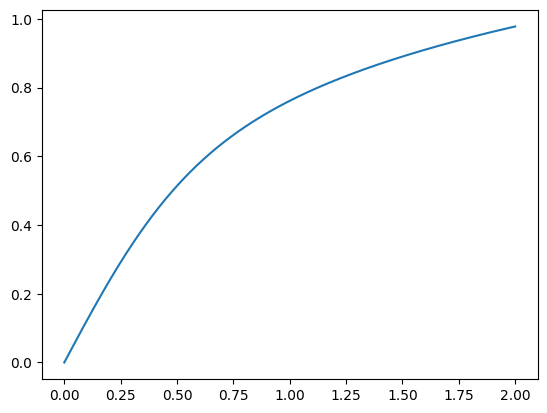

Epoch 4200/3000, loss_g: 0.00044002, loss_f: 0.12407627, lambda=0.559
time elapsed: 1026.1420404911041


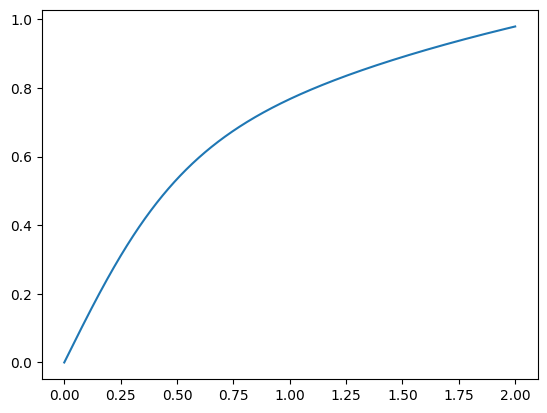

Epoch 4500/3000, loss_g: 0.00038999, loss_f: 0.11639418, lambda=0.565
time elapsed: 1095.6993417739868


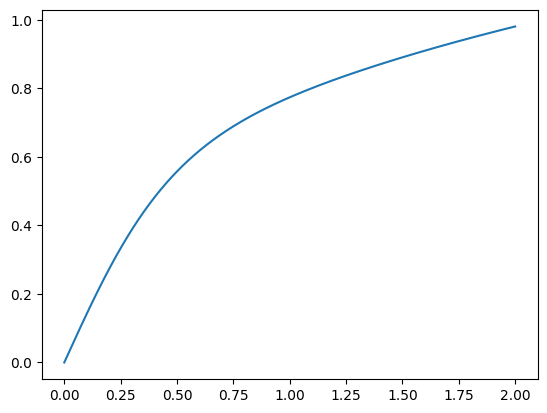

Epoch 4800/3000, loss_g: 0.00035112, loss_f: 0.11020816, lambda=0.568
time elapsed: 1162.8492455482483


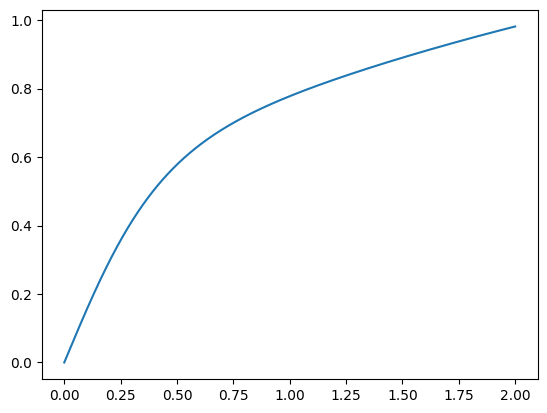

Epoch 5100/3000, loss_g: 0.00032186, loss_f: 0.10472297, lambda=0.568
time elapsed: 1225.6870701313019


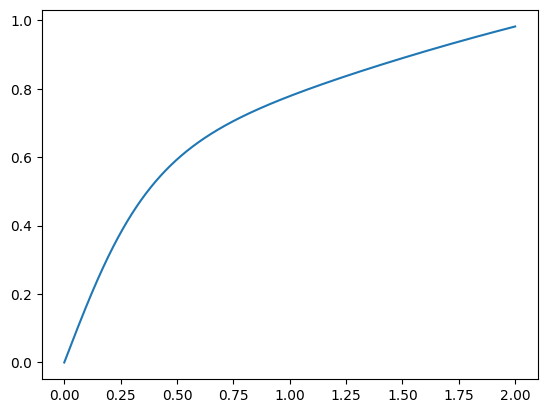

Epoch 5400/3000, loss_g: 0.00029848, loss_f: 0.09936788, lambda=0.567
time elapsed: 1291.851939201355


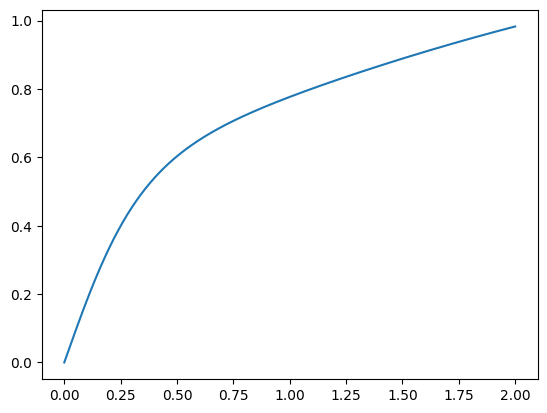

Epoch 5700/3000, loss_g: 0.00027766, loss_f: 0.09411352, lambda=0.566
time elapsed: 1361.2083342075348


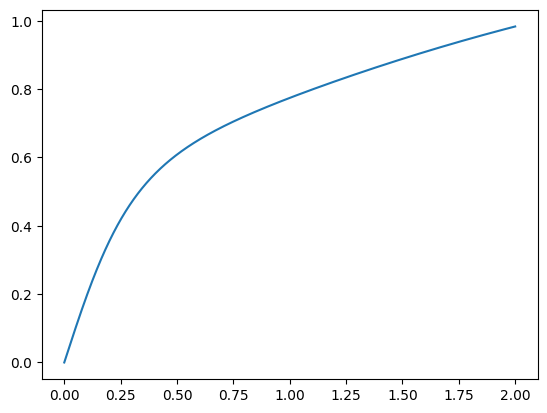

Epoch 6000/3000, loss_g: 0.00025756, loss_f: 0.08912729, lambda=0.564
time elapsed: 1426.600756406784


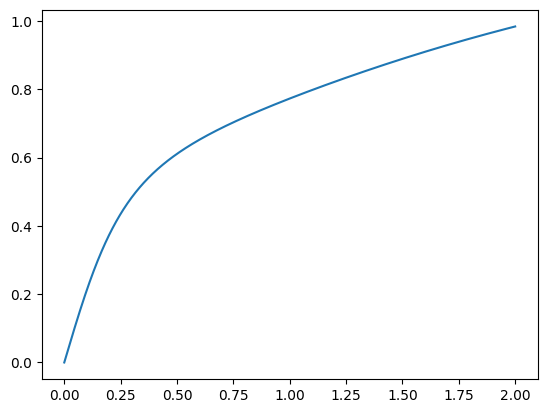

Epoch 6300/3000, loss_g: 0.00023835, loss_f: 0.08451229, lambda=0.564
time elapsed: 1491.4763321876526


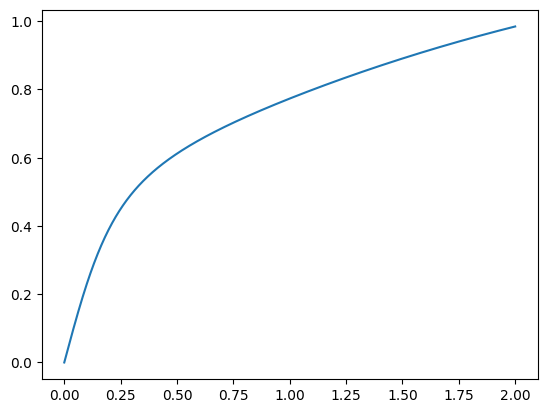

Epoch 6600/3000, loss_g: 0.00022089, loss_f: 0.08037839, lambda=0.564
time elapsed: 1554.4430074691772


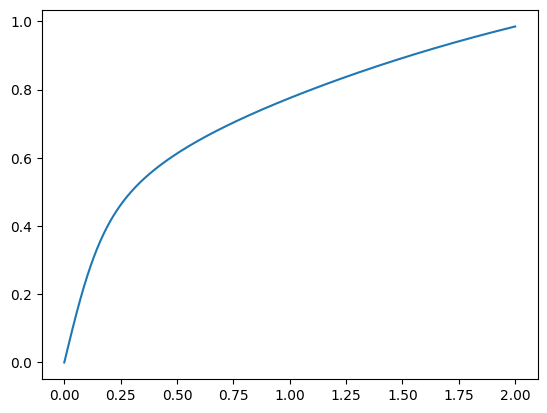

Epoch 6900/3000, loss_g: 0.00020576, loss_f: 0.07686113, lambda=0.565
time elapsed: 1618.4841496944427


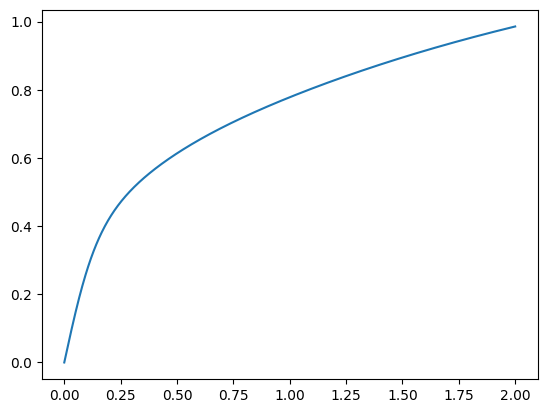

Epoch 7200/3000, loss_g: 0.00019322, loss_f: 0.07403993, lambda=0.565
time elapsed: 1683.256433725357


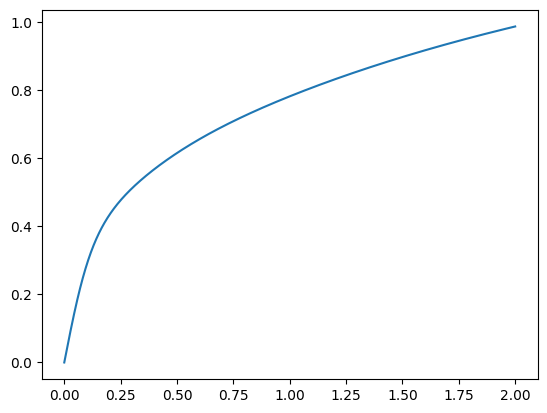

Epoch 7500/3000, loss_g: 0.00018314, loss_f: 0.07186654, lambda=0.566
time elapsed: 1760.760279417038


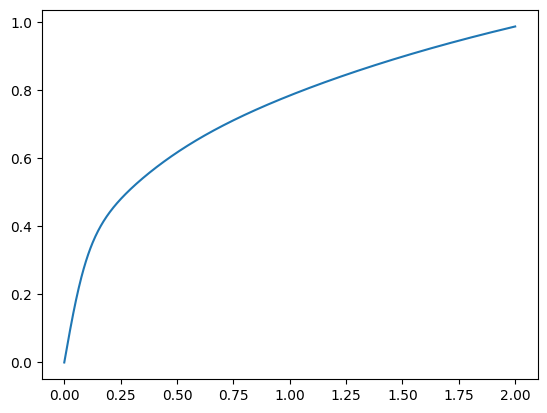

Epoch 7800/3000, loss_g: 0.00017509, loss_f: 0.07018290, lambda=0.566
time elapsed: 1837.7665197849274


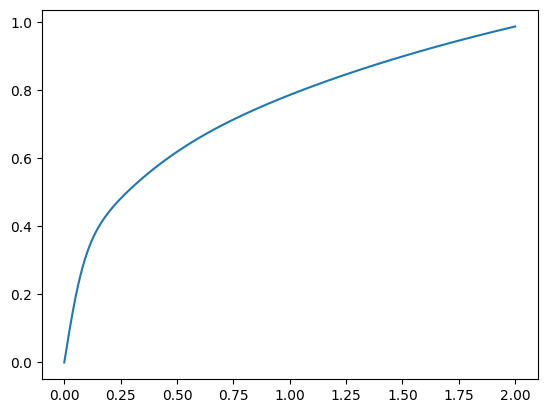

Epoch 8100/3000, loss_g: 0.00016858, loss_f: 0.06881362, lambda=0.566
time elapsed: 1910.614535331726


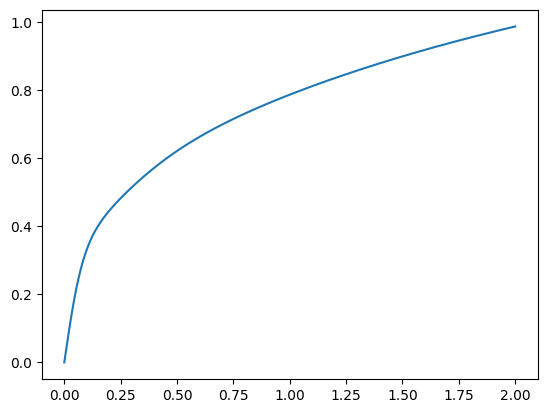

Epoch 8400/3000, loss_g: 0.00016318, loss_f: 0.06763846, lambda=0.566
time elapsed: 1982.2948455810547


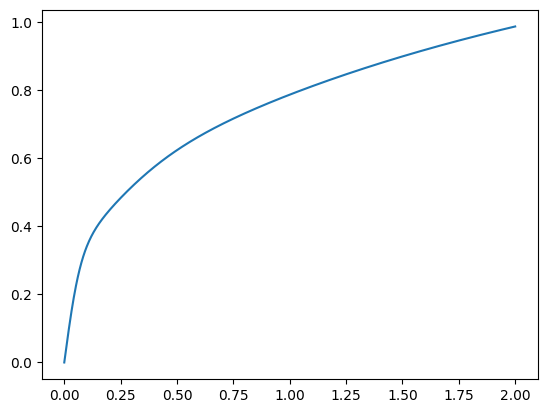

KeyboardInterrupt: 

In [ ]:
model=burgers(1,2, N=5000)
model.Train()

In [ ]:
#check
model=burgers(1,2, N=5000)
cpts= torch.cat((torch.sinh(2.0*torch.tensor([random.random() for i in range(5000)], requires_grad=True)), torch.sinh(5.0*torch.tensor([random.random() for i in range(5000)], requires_grad=True))))
cpts=cpts.view(10000, 1)
U = (model.Model(cpts)[:,0] - model.Model(-1*cpts)[:,0])/2.0
print(U.shape)
Uy=grad(U,cpts)[0].view(10000)
print(Uy.shape)
lamda=model.Model(cpts)[:,1].mean()
f1=-lamda*U #Model takes ([500,1])shape input #But this equation has to have input as a ([500]) vector
print(f1.shape)
f2=Uy*((1+lamda)*cpts.view(10000) + U)
f=f1+f2
f=f**2
print(f.mean())



torch.Size([10000])
torch.Size([10000])
torch.Size([10000])
tensor(0.0001, grad_fn=<MeanBackward0>)


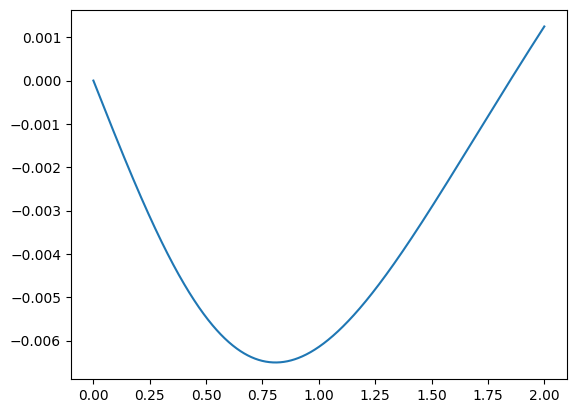

In [ ]:
y=np.linspace(0,2,1000)
yin=torch.tensor(y).view(1000,1)
U = (model.Model(yin)[:,0] - model.Model(-1*yin)[:,0])/2.0
Uout=U.detach().numpy()
#print(Uout.shape)
plt.plot(y,Uout)
plt.show()

In [ ]:
a=torch.tensor([1,1,1])
b=a-a.view(3)+2*a #Oh wow!
b=b**2
b.shape


torch.Size([3])

In [ ]:
#Make an NN (try #1)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class burgers(torch.nn.Module):
    def __init__(
        self,
        #name,
        input_dim, #1, y(x and t)
        output_dim, #2, U and lambda
        N=100,
        epochs=3000,
        #viscosity=False,
        #mu=0.00,
        #loss=nn.MSELoss(),
        lr=1e-4,
        #loss2=None,
       # loss2_weight=0.1,
    ): #-> None:
        super().__init__()

        self.epochs = epochs
        #self.loss = loss
        #self.loss2_weight = loss2_weight
        self.lr = lr
        #self.mu=mu
        #self.viscosity=viscosity
        self.N = N
        #self.name=name

        self.layers = nn.Sequential(
            nn.Linear(input_dim, 20), #the linear transform part https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
            nn.Tanh(), #the activation func I changed to tanh
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),

        )
        self.out = nn.Linear(20, output_dim) #the final transform

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)
        return out

# yinput - model - lambda
# inside loss evaluation: take x, t, and self.Model's lambda --> create y  ?But self.Model cannot give lambda without y
# then evaluate self.Model(y) against reality(y)==0 for boundary loss      ? fix: maybe we set lamda init to be 1 and go from there


    def Train(self):
        print(self.N)

        # CHECK!

        yinit = torch.tensor([random.random() for i in range(2*self.N)]) #t=0
        outputinit=torch.sin(np.pi*yinit)

        #put this inside boundary loss!!
        xboundary=torch.hstack((torch.zeros(self.N), torch.ones(self.N)))
        timeboundary= torch.tensor([random.random() for i in range(2*self.N)])
        outputboundary= torch.zeros(2*self.N)
        Routputboundary=torch.cat((outputinit, outputboundary))

        #for cpts use y=sinh(random), as tristan paper
        cpts=torch.sinh(2.0*torch.tensor([random.random() for i in range(10*self.N)], requires_grad=True))
        cpts=cpts.view(10*self.N, 1)
        #cpts=torch.hstack(torch.tensor([random.random() for i in range(2*self.N)]), torch.tensor([random.random() for i in range(2*self.N)]

        # xcpts=torch.hstack(torch.tensor([random.random() for i in range(2*self.N)]), torch.tensor([random.random() for i in range(2*self.N)])/1000.0) #Oversamples near the origin?
        # cpts = torch.column_stack((torch.tensor([random.random() for i in range(2*self.N)], requires_grad=True), torch.tensor([random.random() for i in range(2*self.N)], requires_grad=True)))

        start=time.time()
        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train() #https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch


        def loss_g(inputs, outputs):
          loss=(inputs-outputs)**2
          return loss.mean()

        def loss_f(input, lamda):
          U=self.Model(input)[:,0]
          Uy=grad(U,input)[0]

          return ((-lamda*U + Uy*((1+lamda)*input + U))**2).mean()

        # def loss_fv(input):
        #   U=self.Model(input)[:,0]
        #   a=grad(U,input)[0]
        #   Ux=a[:,0]
        #   Ut=a[:,1]
        #   Uxx=grad(Ux,input[0])
        #   return ((Ut+U*Ux-self.mu*Uxx)**2).mean()

          if self.viscosity==True:
            loss_f=loss_fv
          else:
            pass

        for ep in range(self.epochs):
            optimiser.zero_grad()

            lamda = self.Model(cpts)[:,1].mean() #CHECK!
            yboundary = xboundary/((1.0-timeboundary)**(1+lamda)) #CHECK!
            inputboundary=torch.cat((yinit, yboundary))#CHECK!
            inputboundary=inputboundary.view(4*self.N,1)
            Moutputboundary = self.Model(inputboundary)[:,1]

            loss = loss_g(Routputboundary, Moutputboundary) + loss_f(cpts, lamda)
            loss.backward(retain_graph=True) #this is Gemini suggestion
            optimiser.step()



            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss_g: {loss_g(Routputboundary, Moutputboundary).item():.8f}, loss_f: {loss_f(cpts,lamda).item():.8f}, lambda={lamda:.3}")
                print('time elapsed: {}'.format(time.time()-start))
                y=np.linspace(0,2,1000)
                yin=torch.tensor(y).view(1000,1)
                Uout=model.Model(yin)[:,0].detach().numpy()
                print(Uout.shape)
                plt.plot(y,Uout)
                plt.legend()
                plt.show()
        return ()

    def Model(self, X):
        self.eval()
        out = self.forward(X)
        return out #.detach().cpu().numpy()


In [ ]:
#Make an NN (try #2)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class burgers(torch.nn.Module):
    def __init__(
        self,
        input_dim, #1, y(x and t)
        output_dim, #2, U and lambda
        N=100,
        epochs=3000,
        lr=1e-4,
    ):
        super().__init__()

        self.epochs = epochs
        self.lr = lr
        self.N = N

        self.layers = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
        )
        self.out = nn.Linear(20, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)
        return out


    def Train(self):

        yinit = torch.tensor([random.random() for i in range(2*self.N)]) #t=0
        outputinit=torch.sin(np.pi*yinit)

        xboundary=torch.hstack((torch.zeros(self.N), torch.ones(self.N)))
        timeboundary= torch.tensor([random.random() for i in range(2*self.N)])
        outputboundary= torch.zeros(2*self.N)
        Routputboundary=torch.cat((outputinit, outputboundary))

        #for cpts use y=sinh(random), as tristan paper
        cpts=torch.sinh(2.0*torch.tensor([random.random() for i in range(5*self.N)], requires_grad=True))
        cpts=cpts.view(5*self.N, 1)

        start=time.time()
        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train() #https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch


        def loss_g():
          loss=(self.Model(torch.tensor([-2.0]).view(1,1))[:,0]- 1.0)**2 #I'm supposed to do away with the (inputs-outputs)**2 condition??
          return loss.mean()

        def loss_f(input, lamda):
          U=self.Model(input)[:,0]
          Uy=grad(U,input)[0]

          return ((-lamda*U + Uy*((1+lamda)*input + U))**2).mean()

        for ep in range(self.epochs):
            optimiser.zero_grad()

            lamda = self.Model(cpts)[:,1].mean() #CHECK!
            # yboundary = xboundary/((1.0-timeboundary)**(1+lamda)) #CHECK!
            # inputboundary=torch.cat((yinit, yboundary))#CHECK!
            # inputboundary=inputboundary.view(4*self.N,1)
            # Moutputboundary = self.Model(inputboundary)[:,1]

            loss = loss_g() + loss_f(cpts, lamda)
            loss.backward(retain_graph=True) #this is Gemini suggestion
            optimiser.step()



            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss_g: {loss_g().item():.8f}, loss_f: {loss_f(cpts,lamda).item():.8f}, lambda={lamda:.3}")
                print('time elapsed: {}'.format(time.time()-start))
                y=np.linspace(0,2,1000)
                yin=torch.tensor(y).view(1000,1)
                Uout=model.Model(yin)[:,0].detach().numpy()
                print(Uout.shape)
                plt.plot(y,Uout)
                plt.show()
        return ()

    def Model(self, X):
        self.eval()
        out = self.forward(X)
        return out #.detach().cpu().numpy()

In [ ]:
#Make an NN (try #3)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class burgers(torch.nn.Module):
    def __init__(
        self,
        input_dim, #1, y(x and t)
        output_dim, #2, U and lambda
        N=100,
        epochs=3000,
        lr=1e-4,
    ):
        super().__init__()

        self.epochs = epochs
        self.lr = lr
        self.N = N

        self.layers = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
        )
        self.out = nn.Linear(20, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)
        return out


    def Train(self):

        #for cpts use y=sinh(random), as tristan paper
        cpts=torch.sinh(2.0*torch.tensor([random.random() for i in range(5*self.N)], requires_grad=True))
        cpts=cpts.view(5*self.N, 1)

        start=time.time()
        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train() #https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch


        def loss_g():
          U_2=(self.Model(torch.tensor([2.0]).view(1,1))[:,0] - self.Model(torch.tensor([-2.0]).view(1,1))[:,0])/2.0
          loss=(U_2-1.0)**2
          return loss.mean()

        def loss_f(input, lamda):
          U = (self.Model(input)[:,0] - self.Model(-1*input)[:,0])/2.0 #the odd part of the model
          # print('---------------')
          # print(U.shape)
          # print(U[1])
          Uy=grad(U,input)[0].view(5*self.N)
          # print(Uy.shape)
          # print(Uy[1])
          # print('lambda shape')
          # print(lamda.shape)
          # print(lamda)
          # print('input')
          # print(input.view(5*self.N)[1])

          # print('f1')
          f1=-lamda*U #Model takes ([500,1])shape input #But this equation has to have input as a ([500]) vector
          # print(f1.shape)
          # print('f2')
          f2=Uy*((1+lamda)*input.view(5*self.N) + U)
          # print(f2.shape)

          # print('f')
          f=f1+f2
          # print(f.shape)
          # print('f again')
          f=f**2
          # print(f.shape)

          # print(f[1])



          return f.mean()

        loss=1000
        ep=0

        while loss>=1e-4:
            optimiser.zero_grad()

            lamda = self.Model(cpts)[:,1].mean()
            lossg=loss_g()
            lossf=loss_f(cpts, lamda)
            l=(lamda-.5)**2
            loss = lossg + .1*lossf + l
            loss.backward(retain_graph=True) #this is Gemini suggestion
            optimiser.step()
            ep+=1

            if ep % int(self.epochs / 10) == 0:

              checkpts=torch.cat((torch.sinh(3.0*torch.tensor([random.random() for i in range(7*self.N)], requires_grad=True)), torch.sinh(5.0*torch.tensor([random.random() for i in range(3*self.N)], requires_grad=True))))
              checkpts=checkpts.view(10*self.N, 1)
              lamdaout=self.Model(checkpts)[:,1].mean()
              outofsamplelossf=loss_f(checkpts, lamdaout)


              print(f"Epoch {ep}/{self.epochs}, g: {lossg:.8f}, InSamf: {lossf:.8f}, OutSamf= {outofsamplelossf:.8}, InLambda={lamda:.3}, OutLambda={lamdaout:.3}")
              print('time elapsed: {}'.format(time.time()-start))
              y=np.linspace(0,2,1000)
              yin=torch.tensor(y).view(1000,1)
              U = (self.Model(yin)[:,0] - self.Model(-1*yin)[:,0])/2.0
              Uout=U.detach().numpy()
              #print(Uout.shape)
              plt.plot(y,Uout)
              plt.show()
        return ()

    def Model(self, X):
        self.eval()
        out = self.forward(X)
        return out #.detach().cpu().numpy()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')